In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import box, MultiPolygon,Polygon,shape
import rasterio as rs
from rasterio import mask
from rasterio.features import geometry_mask
from rasterio.windows import Window,from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_geom

import matplotlib.pyplot as plt

import psycopg2
from getpass import getpass

from PIL import Image
from glob import glob
from tqdm import tqdm
from typing import Union
import os,sys,glob,warnings,random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use("bmh")

# Process Wind Damage Map

In [4]:
image_path = 'DATA/storm_paula_2021/'

In [5]:
inf_img = rs.open(image_path+'damage_map_full_raw_fts.tif')

In [6]:
inf_img.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 8425,
 'height': 6101,
 'count': 4,
 'crs': CRS.from_epsg(3067),
 'transform': Affine(9.999999999864654, 0.0, 559999.9999991764,
        0.0, -9.99999999986414, 7302009.9999594465)}

In [7]:
# Define the banding box
left = 560000
right = left + 60000
bottom = 7242000.000
top = bottom + 60000

In [8]:
geom = box(left,bottom, right, top)

In [9]:
minx, miny, maxx, maxy = geom.bounds

In [10]:
# Select the subset of the image
out_image, out_transform = mask.mask(inf_img, [geom], crop=True, nodata=0,all_touched=False)

In [11]:
out_image.shape

(4, 6001, 6001)

## Binrizing the image based on band 2 (damaged band) with threshold 0.5 to two classes
`2: damaged 1:Undamaged`

In [12]:
undmaged_band = out_image[1]
undmaged_band.shape

(6001, 6001)

In [13]:
binary_image = np.where(undmaged_band > 0.5 , 1, 0)

In [14]:
binary_image.shape

(6001, 6001)

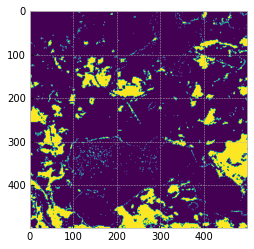

In [15]:
plt.imshow(binary_image[2000:2500,2000:2500])
plt.show()

In [16]:
out_path = './processed_DATA/binrized_image.tif'

In [17]:
with rs.open(out_path,"w",
                   driver='GTiff',
                   count=1,
                   transform = out_transform,
                   width= binary_image.shape[1],
                   height= binary_image.shape[0],
                   nodata=0,
                   dtype='int16',
                   crs=inf_img.crs) as output_file:
    output_file.write(binary_image.reshape(1,6001, 6001).astype('int16'))

# Forest mask
`gdalwarp -overwrite -co BIGTIFF=YES -co COMPRESS=LZW -multi -wo NUM_THREADS=10 -r bilinear -s_srs EPSG:3035 -t_srs EPSG:3067 /mnt/archive-telum/geodata/land-cover/europe/copernicus-land/copernicus- land-2018/fi-tcd-merged.tif forest_mask_3067_bilinear.tif`

In [18]:
# Allighn the forest mask with damaged map
forest_mask = rs.open('./DATA/forest_mask_3067_bilinear.tif')
forest_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 113996,
 'height': 156009,
 'count': 1,
 'crs': CRS.from_epsg(3067),
 'transform': Affine(9.968436622051547, 0.0, -98006.10770901025,
        0.0, -9.968436622051547, 7943653.5473182835)}

In [19]:
def align_boundry(original_img,source_img,out_path):
    """
    original_img: The image should be mapped to the source image
    source_image: The image which should not be changed
    """
    original_ = rs.open(original_img)
    source_ = rs.open(source_img)
    minx,miny,maxx,maxy = source_.bounds
    window = from_bounds(minx, miny, maxx, maxy, transform=original_.transform)
    width=source_.width
    height=source_.height
    transform = rs.transform.from_bounds(minx,miny,maxx,maxy, width, height)
    result = original_.read(window=window,out_shape=(height,width),resampling=1)
    with rs.open(out_path, "w",
           driver='GTiff',
           count=original_.count,
           transform = transform,
           width=width,
           height=height,
           dtype=result.dtype,
           nodata=0,
           crs="epsg:3067",) as output_file:
        output_file.write(result)

In [20]:
align_boundry('./DATA/forest_mask_3067_bilinear.tif','./processed_DATA/binrized_image.tif','./processed_DATA/forest_mask_align_bb.tif')

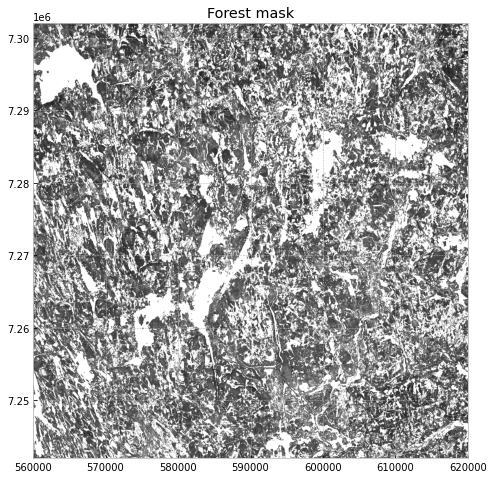

In [21]:
plt.figure(figsize=(8,8))
aligned_forest_mask = rs.open('./processed_DATA/forest_mask_align_bb.tif').read()
plt.imshow(aligned_forest_mask.T,extent=(minx, maxx, miny, maxy),cmap=plt.cm.get_cmap('gray_r'))
plt.title('Forest mask')
plt.show()

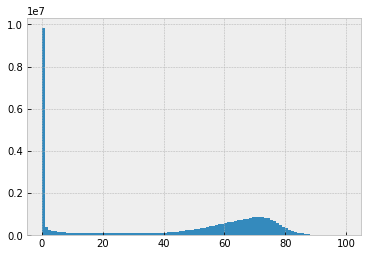

In [22]:
plt.hist(aligned_forest_mask.flatten(),bins=100)
plt.show()

# Generate random patches

In [23]:
aoi_df = gpd.GeoSeries([geom])

In [24]:
PATCH_S = 640
NUM_PATCHES = 100000

In [25]:
patches = gpd.GeoSeries.from_xy(*(np.random.randint(0,6000,(2,NUM_PATCHES))*10) + np.array([[minx],[miny]]))

In [26]:
patches = patches.apply(lambda p: box(p.x, p.y, p.x + PATCH_S, p.y + PATCH_S))

In [27]:
patches.crs = "EPSG:3067"

## Fetch the water mask from DB

In [28]:
password = getpass()

 ············


In [29]:
conn = psycopg2.connect("dbname='ccgeodb' user='behzad' host='forestdb.collectivecrunch.net' password='%s'" % (password))

In [30]:
sql="""WITH temporaryTable (geom) as
    (SELECT sijainti_alue from physical.fi_lakes)
        select geom from temporaryTable
            where ST_Intersects(temporaryTable.geom , ST_MakeEnvelope(559999.9999991764, 7241999.999960275, 620789.2219991763, 7302009.9999594465, 3067)) and ST_Area(temporaryTable.geom) > 20000;"""

In [31]:
water_mask = gpd.GeoDataFrame.from_postgis(sql, conn)

## Select and filter random patches

In [32]:
patches_sample = patches.sample(30000)

In [33]:
# Water mask should be Mutipolygon to be able to intersect with patches
mp = MultiPolygon(water_mask['geom'].values)

In [34]:
patches_filter = patches_sample[~patches_sample.intersects(mp)]

In [35]:
patches_with_water = patches_sample[patches_sample.intersects(mp)]

In [36]:
def coverage_percentage(patch,water_mask):
    cov_area = patch.intersection(water_mask).area/patch.area
    return cov_area

In [37]:
list_geoms = [shape(feat) for feat in patches_with_water]

In [38]:
coverage_percentage(list_geoms[1256],mp)

0.7470026282859089

In [39]:
list_water_coverage = [coverage_percentage(i,mp) for i in tqdm(list_geoms)]

100%|█████████████████████████████████████████████████████████| 11308/11308 [10:45<00:00, 17.51it/s]


In [40]:
df_patches_with_water = gpd.GeoDataFrame({'water_coverage':list_water_coverage, 'geometry': list_geoms})

In [41]:
selected_patches_with_water = df_patches_with_water['geometry'][df_patches_with_water['water_coverage']<=0.5]

In [42]:
patches_to_extract = pd.concat([patches_filter,selected_patches_with_water]).reset_index(drop=True)

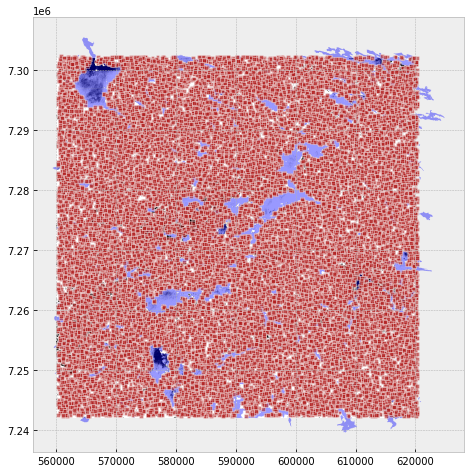

In [43]:
plt.figure(figsize=(8,8))
plt.imshow(binary_image,extent=(minx, maxx, miny, maxy),cmap=plt.cm.get_cmap('gray_r'))
water_mask.plot(ax=plt.gca(), facecolor="blue", alpha=0.4)
patches_to_extract.plot(ax=plt.gca(), facecolor="firebrick", alpha=0.6, edgecolor="w")

plt.show()

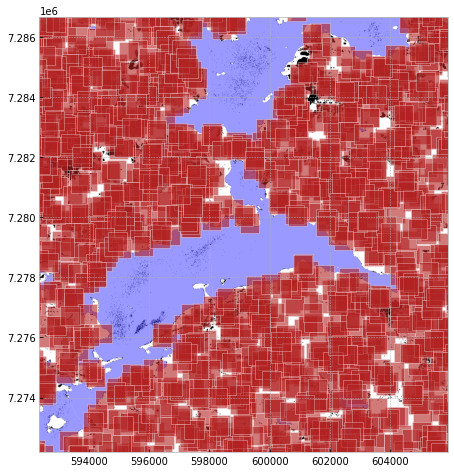

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(binary_image,extent=(minx, maxx, miny, maxy),cmap=plt.cm.get_cmap('gray_r'))
water_mask.plot(ax=plt.gca(), facecolor="blue", alpha=0.4)
patches_to_extract.plot(ax=plt.gca(), facecolor="firebrick", alpha=0.6, edgecolor="w")

plt.gca().set_xlim(592347.821, 605917.290)
plt.gca().set_ylim(7272181.878, 7286642.931)

plt.show()

In [45]:
damage_list=[]
undamage_list = []
rast = rs.open('./processed_DATA/binrized_image.tif')
for g in tqdm(patches_to_extract):
    minx,miny,maxx,maxy = g.bounds
    window = from_bounds(minx, miny, maxx, maxy, transform=rast.transform)
    transform = rs.transform.from_bounds(minx,miny,maxx,maxy, 64, 64)
    out_image = rast.read(window=window,out_shape=(64,64),resampling=0)
    val, counts = np.unique(out_image, return_counts=True)
    if len(val) ==2:
        undamage_list.append(counts[0])
        damage_list.append(counts[1])
    elif val[0]==0:
        undamage_list.append(counts[0])
        damage_list.append(0)
    else:
        damage_list.append(0)
        undamage_list.append(counts[0])

100%|███████████████████████████████████████████████████████| 27457/27457 [00:07<00:00, 3612.47it/s]


In [46]:
patches_with_info = gpd.GeoDataFrame({'geom':patches_to_extract,'damage_counts':damage_list,'undamge_counts':undamage_list},geometry='geom')

In [47]:
patches_with_info.to_file('./processed_DATA/patches_with_info.geojson', driver='GeoJSON')

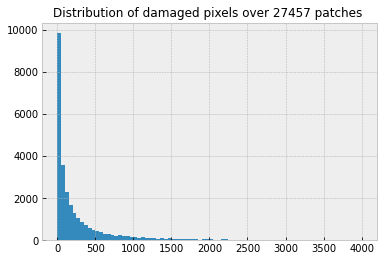

In [48]:
plt.hist(patches_with_info.iloc[:,1],bins=80)
plt.title(f'Distribution of damaged pixels over {len(patches_with_info)} patches ', fontsize=12)
plt.show()

# Prepare SAR data

In [49]:
allfiles = os.listdir('DATA/')
files = [ f'./DATA/{fname}' for fname in allfiles if fname.endswith('.tif')]

In [50]:
files = files[1:]

In [51]:
files #Ascending

['./DATA/mosaic_S1_before_ASC.tif', './DATA/mosaic_S1_after_ASC_2WK.tif']

In [52]:
src = rs.open('./processed_DATA//forest_mask_align_bb.tif')
org = rs.open('./DATA/mosaic_S1_before_ASC.tif')
minx, miny, maxx, maxy = src.bounds
window = from_bounds(minx, miny, maxx, maxy, transform=org.transform)
transform = rs.transform.from_bounds(minx,miny,maxx,maxy, src.width, src.height)

In [53]:
SAR_features_list = [rs.open(img).read(window=window,out_shape=(src.height,src.width)) for img in files]

In [54]:
SAR_features = np.concatenate(SAR_features_list)

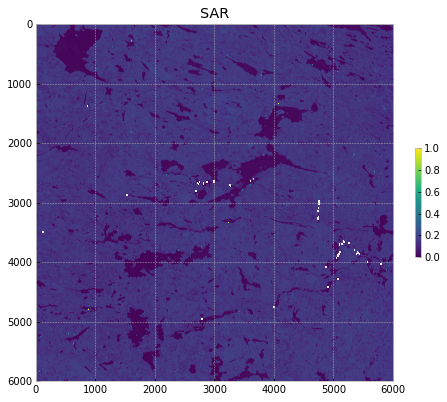

In [55]:
plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(SAR_features,0,2)[...,0],vmin=0,vmax=1)
plt.colorbar(shrink=0.25)
plt.title('SAR')
plt.show()

In [56]:
SAR_features.shape

(4, 6001, 6001)

In [57]:
vv_Bef_ASC = SAR_features[0,...][~np.isinf(SAR_features[0,...])]
vh_Bef_ASC = SAR_features[1,...][~np.isinf(SAR_features[1,...])]
vv_Bef_ASC = vv_Bef_ASC[vv_Bef_ASC<1]
vh_Bef_ASC = vh_Bef_ASC[vh_Bef_ASC<1]

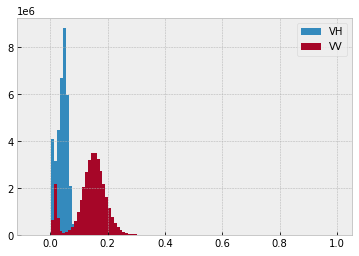

In [59]:
plt.hist(vh_Bef_ASC,bins=100,label='VH')
plt.hist(vv_Bef_ASC,bins=100,label='VV')
plt.legend()
plt.show()

In [60]:
SAR_features = SAR_features.clip(0,0.5) #Consider 0.5 as threshold

In [61]:
EPS = 1e-10

In [62]:
log_SAR_features = np.log(EPS + SAR_features)

In [63]:
vv_log_Bef_ASC = log_SAR_features[0,...][~np.isnan(log_SAR_features[0,...])]
vh_log_Bef_ASC = log_SAR_features[1,...][~np.isnan(log_SAR_features[1,...])]

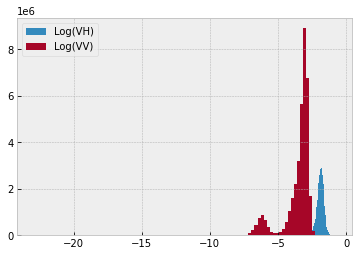

In [64]:
plt.hist(vv_log_Bef_ASC,bins=100,label='Log(VH)')
plt.hist(vh_log_Bef_ASC,bins=100,label='Log(VV)')
plt.legend()
plt.show()

In [65]:
clip_log=-8
norm_log_SAR_features = (np.clip(log_SAR_features, clip_log, 0) - clip_log) / np.abs(clip_log)

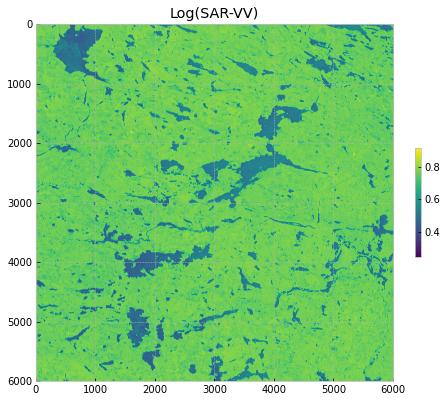

In [66]:
plt.figure(figsize=(8,8))
plt.imshow(np.moveaxis(norm_log_SAR_features,0,2)[...,0])
plt.colorbar(shrink=0.25)
plt.title('Log(SAR-VV)')
plt.show()

In [67]:
SAR_features.shape, norm_log_SAR_features.shape,aligned_forest_mask.shape

((4, 6001, 6001), (4, 6001, 6001), (1, 6001, 6001))

In [68]:
features = np.concatenate([SAR_features,norm_log_SAR_features,aligned_forest_mask/100])
features.shape

(9, 6001, 6001)

In [69]:
features[8,...].max()

1.0

In [70]:
out_path = './processed_DATA/features.tif'
with rs.open(out_path, "w",
       driver='GTiff',
       count=9,
       transform = transform,
       width=src.width,
       height=src.height,
       dtype=features.dtype,
       nodata=0,
       crs="epsg:3067",) as output_file:
    output_file.write(features)

# Training, Testing and Validation Sets

## Seperate Training, testing and validation sets

In [71]:
tr_minX = minx
tr_minY = maxy - 40e3
tr_maxX = minx + 40e3
tr_maxY = maxy
tr_area = box(tr_minX,tr_minY,tr_maxX,tr_maxY)

In [72]:
tt_minX = minx
tt_minY = maxy - 50e3
tt_maxX = minx + 50e3
tt_maxY = maxy
tt_ = box(tt_minX,tt_minY,tt_maxX,tt_maxY)

In [73]:
val_ = box(minx,miny,maxx,maxy)

In [74]:
tt_area = tt_.difference(tr_area)

In [75]:
val_area = val_.difference(tt_)

In [76]:
all_areas = gpd.GeoDataFrame({'geometry':[tr_area,tt_area,val_area], 'label':['Training','Testing','validation']})

In [77]:
all_areas.crs = "EPSG:3067"

In [78]:
patches_with_info = gpd.read_file('./processed_DATA/patches_with_info.geojson')

In [79]:
patches_with_info.tail()

,damage_counts,undamge_counts,geometry
27452,683,3413,"POLYGON ((580570.000 7271650.000, 580570.000 7..."
27453,653,3443,"POLYGON ((610960.000 7268740.000, 610960.000 7..."
27454,575,3521,"POLYGON ((591840.000 7247860.000, 591840.000 7..."
27455,91,4005,"POLYGON ((589750.000 7272200.000, 589750.000 7..."
27456,113,3983,"POLYGON ((612360.000 7279550.000, 612360.000 7..."


In [80]:
patches_with_info.shape

(27457, 3)

In [81]:
train_patches = patches_with_info[patches_with_info.within(all_areas.iloc[0,0])]
test_patches = patches_with_info[patches_with_info.within(all_areas.iloc[1,0])]
validation_patches = patches_with_info[patches_with_info.within(all_areas.iloc[2,0])]

In [83]:
len(train_patches), len(test_patches), len(validation_patches)

(11704, 6442, 7931)

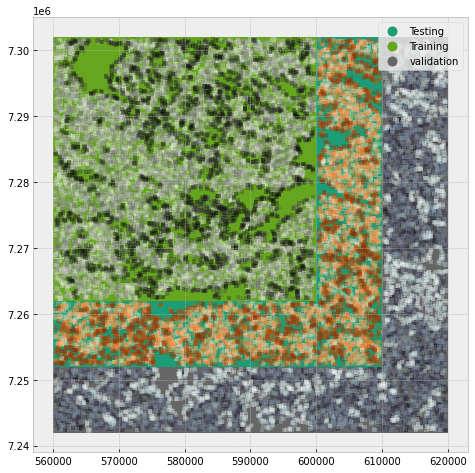

In [84]:
all_areas.plot(column='label',legend=True,cmap='Dark2',figsize=(8, 8))
train_patches.plot(ax=plt.gca(),alpha=0.3,cmap='Greys')
test_patches.plot(ax=plt.gca(),alpha=0.3,cmap='Oranges')
validation_patches.plot(ax=plt.gca(),alpha=0.3,cmap='bone')
plt.show()

In [85]:
train_patches.loc[:, ['label']]='train'
test_patches.loc[:, ['label']]='test'
validation_patches.loc[:, ['label']]='validation'

/home/behzad/cnn_env/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [86]:
patches_train_test_validation = pd.concat([train_patches,
                                                test_patches,
                                                validation_patches])

In [89]:
print(f'The percentage of the damaged pixels in all test patches:{(train_patches.damage_counts.sum()/(train_patches.damage_counts.sum() + train_patches.undamge_counts.sum()))*100:.2f}%')
print(f'The percentage of the damaged pixels in all test patches:{test_patches.damage_counts.sum()/(test_patches.damage_counts.sum() + test_patches.undamge_counts.sum())*100:.2f}%')
print(f'The percentage of the damaged pixels in all validation patches:{validation_patches.damage_counts.sum()/(validation_patches.damage_counts.sum() + validation_patches.undamge_counts.sum())*100:.2f}%')

The percentage of the damaged pixels in all test patches:8.64%
The percentage of the damaged pixels in all test patches:8.20%
The percentage of the damaged pixels in all validation patches:5.18%


In [90]:
patches_train_test_validation.to_file('./processed_DATA/patches_train_test_validation.geojson', driver='GeoJSON')